# MultiGPU training optimization

How many jobs until we start to lose performance?

## Notebook set-up

In [1]:
# Set notebook root to project root
from helper_functions import set_project_root

set_project_root()

# Standard library imports
import multiprocessing as mp
import time
from pathlib import Path

# Third party imports
import matplotlib.pyplot as plt
import pandas as pd

# Local imports
import configuration as config
from model_training import optimize_gpu_workers
from model_training.functions.utils import clear_tensorboard_logs

mp.set_start_method('spawn', force=True)

clear_tensorboard_logs()

Working directory: /mnt/arkk/kaggle/ariel-data-challenge


## 1.1. Optuna runs

In [2]:
worker_nums = [1,2,3,4,5,6,7,8]
results_file = f'{config.EXPERIMENT_RESULTS_DIRECTORY}/multiGPU_optimization_worker-{"-".join(map(str, worker_nums))}.csv'

if Path(results_file).exists() == False:

    results = {
        'worker_count': [],
        'run_time': [],
        'total_steps': []
    }

    for workers in worker_nums:
        print(f'Running optimization with {workers} workers')

        start_time = time.time()

        with mp.Pool(processes=workers) as pool:
            pool.map(optimize_gpu_workers.run, range(workers))

        results['run_time'].append(time.time() - start_time)
        results['worker_count'].append(workers)
        results['total_steps'].append(workers * 4 * 10 * 10)  # workers * optuna runs * epochs * steps_per_epoch

        # Wait a bit before starting the next run
        time.sleep(10)

    results_df = pd.DataFrame(results)
    results_df.to_csv(results_file, index=False)

else:
    results_df = pd.read_csv(results_file)

In [3]:
results_df.head()

,worker_count,run_time,total_steps
0,1,555.535504,400
1,2,675.192083,800
2,3,703.719593,1200
3,4,740.246553,1600
4,5,937.910417,2000


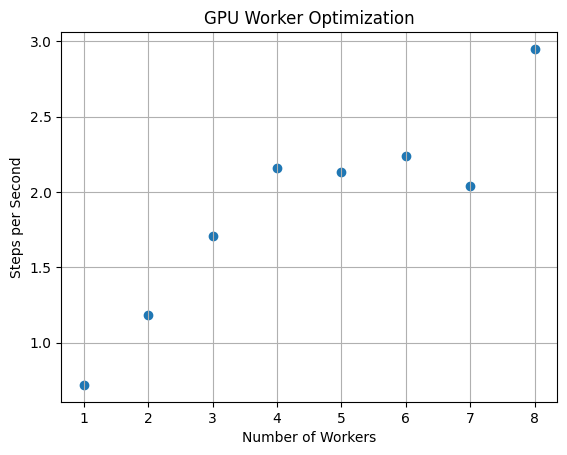

In [4]:
results_df['step_rate'] = results_df['total_steps'] / results_df['run_time']

plt.scatter(results_df['worker_count'], results_df['step_rate'])
plt.xlabel('Number of Workers')
plt.ylabel('Steps per Second')
plt.title('GPU Worker Optimization')
plt.grid(True)
plt.show()